In [53]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import sklearn.linear_model as sl
import scipy.stats as st

In [54]:
ncaa = pd.read_csv("http://www4.stat.ncsu.edu/~boos/var.select/ncaa.data2.txt", 
                   delim_whitespace = True)
x = ncaa.ix[:,:-1]
y = ncaa.ix[:,-1]

In [55]:
def reg_subset(x,y):
    lm = sl.LinearRegression()
    
    in_ = []
    out_ = list(range(x.shape[1]))
    rss = [sum((y-np.mean(y))**2)]
    (n,m) = x.shape
    
    if(m>=n):
        ml = n-5
    else:
        ml = m   
    vm = np.array(range(ml))

    for pi in range(x.shape[1]):
        rss_find = []
        for i in out_:
            fit_X = pd.DataFrame(x.ix[:, in_ + [i]])
            lm.fit(fit_X, y)
            pred = lm.predict(fit_X)
            rss_find.append(sum((pred-y)**2))
        min_rss = np.min(rss_find)
        min_var = out_[rss_find.index(min_rss)]
        rss.append(min_rss)
        in_.append(min_var)
        del out_[rss_find.index(min_rss)]
        in_var = [x.columns[i] for i in in_]
    rss = np.array(rss)
    pv_org = 1 - st.f.cdf((rss[vm] - rss[vm+1])*(n-(vm+2))/rss[vm+1],
                     1,n-(vm+2))
    return (np.array(in_),np.array(in_var),rss[1:], pv_org)

In [56]:
def fsr_fast_pv(pv_orig, m, gam0 = 0.05, digits = 4):
    m1 = len(pv_orig)
    pvm = np.zeros(m1)

    # create monotone p-values
    for i in range(0, m1):
        pvm[i] = np.max(pv_orig[0:(i+1)])
    alpha = np.concatenate([np.array([0]), pvm])
    ng = len(alpha)
    
    # calculate model size
    S = np.zeros(ng)
    for j in range(1, ng):
        S[j] = sum(pvm <= alpha[j])
        
    # calculate gamma hat
    ghat = (m - S)*alpha/(1 + S)
    
    # add additional points to make jumps
    alpha2 = alpha[1:ng] - 0.0000001
    ghat2 = (m - S[0:(ng - 1)])*alpha2/(1 + S[0:(ng - 1)])
    zp = pd.DataFrame({'a': np.concatenate([alpha, alpha2]), 'g': np.concatenate([ghat, ghat2])})
    zp.sort_values(by =['a', 'g'], ascending = [True, False], inplace = True)
    
    # largest gamma hat and index
    gamma_max = np.argmax(zp['g'])
    
    alpha_max = zp['a'][gamma_max]

    # model size with ghat just below gam0
    ind = np.logical_and(ghat <= gam0, alpha <= alpha_max)*1
    Sind = S[np.max(np.where(ind > 0))]
    
    # calculate alpha_F
    alpha_fast = (1 + Sind)*gam0/(m - Sind)
    
    # size of model including intercept
    size1 = sum(pvm <= alpha_fast) + 1
    
    # generate plot
    plt.plot(zp['a'], zp['g'], marker = 'o', markersize = 6)
    plt.ylabel('Estimated Gamma')
    plt.xlabel('Alpha')
    pass

    df1 = pd.DataFrame({'pval': pv_orig, 'pvmax': pvm, 'ghigh': ghat2, 'glow': ghat[1:ng]}, columns = ['pval', 'pvmax', 'ghigh', 'glow'])
    print(np.round(df1, digits))
    df2 = pd.DataFrame()
    print(pd.DataFrame({'m1': m1, 'm': m, 'gam0': gam0, 'size': size1 - 1, 'alphamax': alpha_max, 'alpha_fast': alpha_fast}, columns = ['m1', 'm', 'gam0', 'size', 'alphamax', 'alpha_fast'], index=[0]))
    
    return[np.round(df1, digits), alpha_fast, alpha_max, gam0]

In [57]:
def fsr_fast(x, y, gam0 = 0.05,digits = 4,print = True, plot = True):
    """
    Estimated alpha for forward selection using Fast FSR(no simulation)
    """
    
    df = pd.concat([x,y], axis = 1)
    x = df.ix[:,:-1]
    y = df.ix[:,-1]

    out = reg_subset(x,y)
    pv_orig = out[3]
    m = len(pv_orig)
    return(fsr_fast_pv(pv_orig, m))    

      pval   pvmax   ghigh    glow
0   0.0000  0.0000 -0.0000  0.0000
1   0.0001  0.0001  0.0006  0.0004
2   0.0116  0.0116  0.0656  0.0270
3   0.0053  0.0116  0.0270  0.0270
4   0.0025  0.0116  0.0270  0.0270
5   0.0433  0.0433  0.1011  0.0804
6   0.0527  0.0527  0.0979  0.0791
7   0.1056  0.1056  0.1584  0.0864
8   0.0826  0.1056  0.0864  0.0864
9   0.0536  0.1056  0.0864  0.0864
10  0.2350  0.2350  0.1922  0.1566
11  0.2864  0.2864  0.1910  0.1542
12  0.3163  0.3163  0.1703  0.1054
13  0.2697  0.3163  0.1054  0.1054
14  0.4953  0.4953  0.1651  0.1238
15  0.6326  0.6326  0.1582  0.1116
16  0.7056  0.7056  0.1245  0.0784
17  0.8605  0.8605  0.0956  0.0453
18  0.9032  0.9032  0.0475  0.0000
   m1   m  gam0  size  alphamax  alpha_fast
0  19  19  0.05     5  0.234958    0.021429


[      pval   pvmax   ghigh    glow
 0   0.0000  0.0000 -0.0000  0.0000
 1   0.0001  0.0001  0.0006  0.0004
 2   0.0116  0.0116  0.0656  0.0270
 3   0.0053  0.0116  0.0270  0.0270
 4   0.0025  0.0116  0.0270  0.0270
 5   0.0433  0.0433  0.1011  0.0804
 6   0.0527  0.0527  0.0979  0.0791
 7   0.1056  0.1056  0.1584  0.0864
 8   0.0826  0.1056  0.0864  0.0864
 9   0.0536  0.1056  0.0864  0.0864
 10  0.2350  0.2350  0.1922  0.1566
 11  0.2864  0.2864  0.1910  0.1542
 12  0.3163  0.3163  0.1703  0.1054
 13  0.2697  0.3163  0.1054  0.1054
 14  0.4953  0.4953  0.1651  0.1238
 15  0.6326  0.6326  0.1582  0.1116
 16  0.7056  0.7056  0.1245  0.0784
 17  0.8605  0.8605  0.0956  0.0453
 18  0.9032  0.9032  0.0475  0.0000,
 0.021428571428571432,
 0.23495846851853724,
 0.05]

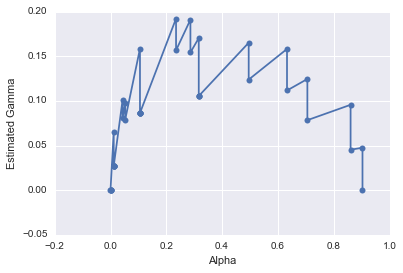

In [58]:
fsr_fast(x,y)